In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [71]:
f_sixb = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"

f_bias = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/bias/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"
# f_sixb = "/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel//NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"


In [4]:
sixb = ObjIter([Tree(f_sixb)])

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [72]:
bias = ObjIter([Tree(f_bias)])

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


In [75]:
bias[0].sample = 'bias signal'

In [7]:
def use_uscms(flist):
    return [ f.replace('/store/user/ekoenig/8BAnalysis/NTuples/2018','/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag') for f in flist ]
    # return [ '/eos/uscms'+f.replace('/store/user/ekoenig/8BAnalysis/NTuples/2018','/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag') for f in flist ]
    # return flist

In [8]:
qcd = ObjIter([Tree( use_uscms(fc.eightb.QCD_bEn_List) )])

100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


In [9]:
model = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/hy_jet_classifier/20221111_ranger_lr0.0047_batch512/"

In [10]:
t6btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag,axis=1)<6)
sixb = sixb.apply(t6btag)
qcd = qcd.apply(t6btag)

In [11]:
def load_hy_jet_classifier(t, model=model):
    fields = ['h1_score','h1_index','h2_score','h2_index'] #+ ['gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi','gnn_hx_dr']
    weaver = eightb.load_weaver_output(t, model, fields=fields)
    h1_score, h1_index = [ weaver[field] for field in ('h1_score','h1_index') ]
    h2_score, h2_index = [ weaver[field] for field in ('h2_score','h2_index') ]

    h1_index = h1_index.astype(int)
    h1_index = np.sort(h1_index, axis=-1).reshape(-1,1,2)
    h1_index = ak.from_regular(h1_index, axis=1)
    
    h2_index = h2_index.astype(int)
    h2_index = np.sort(h2_index, axis=-1).reshape(-1,1,2)
    h2_index = ak.from_regular(h2_index, axis=1)

    jet_index = ak.local_index(t.jet_pt,axis=-1)
    hx_index = jet_index[sum([  jet_index != h[:,0,i] for h in (h1_index, h2_index) for i in range(2) ]) == 4][:,None]
    
    higgs_index = ak.concatenate([hx_index, h1_index, h2_index], axis=1)
    build_all_dijets(t, pairs=higgs_index, name='gnn_higgs')

    t.extend(
        gnn_h1_j1_score=h1_score[:,0], gnn_h1_j2_score=h1_score[:,1],
        gnn_h2_j1_score=h2_score[:,0], gnn_h2_j2_score=h2_score[:,1]
    )

In [12]:
# (sixb).apply(load_hy_jet_classifier)
(sixb+qcd).apply(load_hy_jet_classifier)


[None, None]

In [13]:
def build_gnn_y(t):
    gnn_higgs = get_collection(t, 'gnn_higgs', False)[:,1:]

    h_p4 = build_p4(gnn_higgs)
    y_p4 = h_p4[:,0] + h_p4[:,1]
    y_dr = calc_dr_p4(h_p4[:,0], h_p4[:,1])

    y_id = 1*ak.all(gnn_higgs.signalId>0,axis=-1)

    t.extend(
        gnn_y_id = y_id,
        gnn_y_dr = y_dr,
        **{
            f'gnn_y_{var}':getattr(y_p4, var)
            for var in ('pt','m','eta','phi')
        }
    )

(sixb+qcd).apply(build_gnn_y)

[None, None]

In [14]:
def hy_mask(t):
    sigId = (t.jet_signalId+2)//2
    mask = ak.sum(sigId == 1,axis=-1) == 2
    return mask


In [15]:
varinfo.gnn_higgs_m = dict(bins=(0,500,30))


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


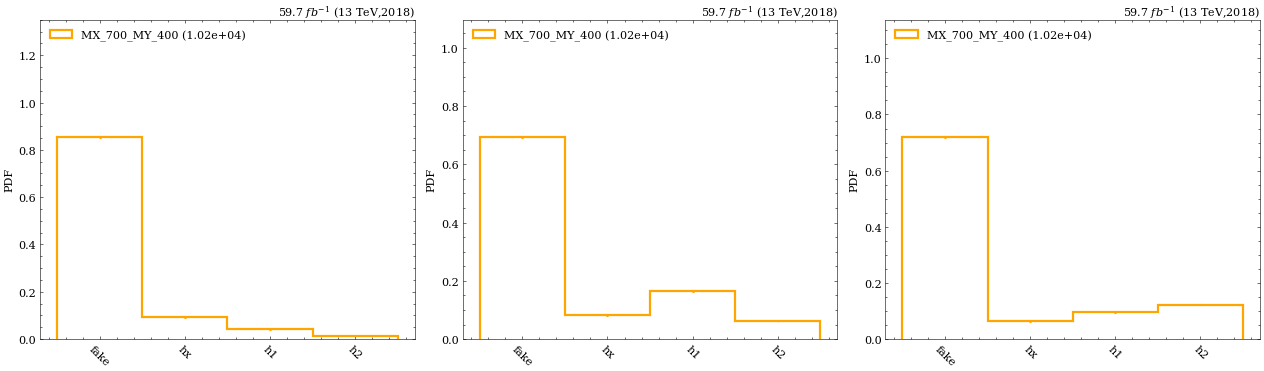

In [16]:
varinfo.gnn_higgs_signalId = dict(xlabel=['fake','hx','h1','h2'])
study.quick(
    sixb,
    legend=True,
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=[f'gnn_higgs_signalId[:,{i}]' for i in range(3)],
    efficiency=True,
    dim=-1,
)

In [31]:
def h1_mask(t):
    sigId = (t.jet_signalId+2)//2
    mask = ak.sum(sigId == 2,axis=-1) == 2
    return mask
def h2_mask(t):
    sigId = (t.jet_signalId+2)//2
    mask = ak.sum(sigId == 3,axis=-1) == 2
    return mask
def hy_mask(t):
    return h1_mask(t) & h2_mask(t)
def hx_mask(t):
    sigId = (t.jet_signalId+2)//2
    mask = ak.sum(sigId == 1,axis=-1) == 2
    return mask
def complete_mask(t):
    return hx_mask(t) & hy_mask(t)

In [78]:
def count_gnn_higgs(t):
    nhiggs = ak.sum(t.gnn_higgs_signalId > -1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)
(sixb+qcd).apply(count_gnn_higgs)

[None, None]

100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


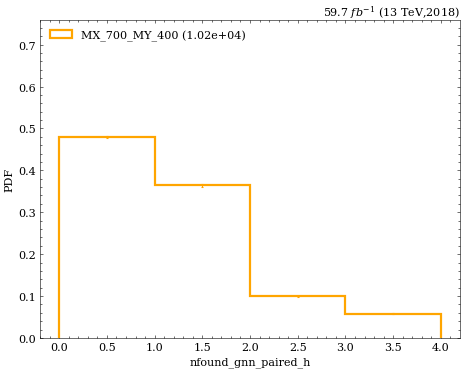

In [46]:
study.quick(
    sixb,
    legend=True,
    varlist=['nfound_gnn_paired_h'],
    efficiency=True,
)

100%|██████████| 6/6 [00:00<00:00, 11.75it/s]


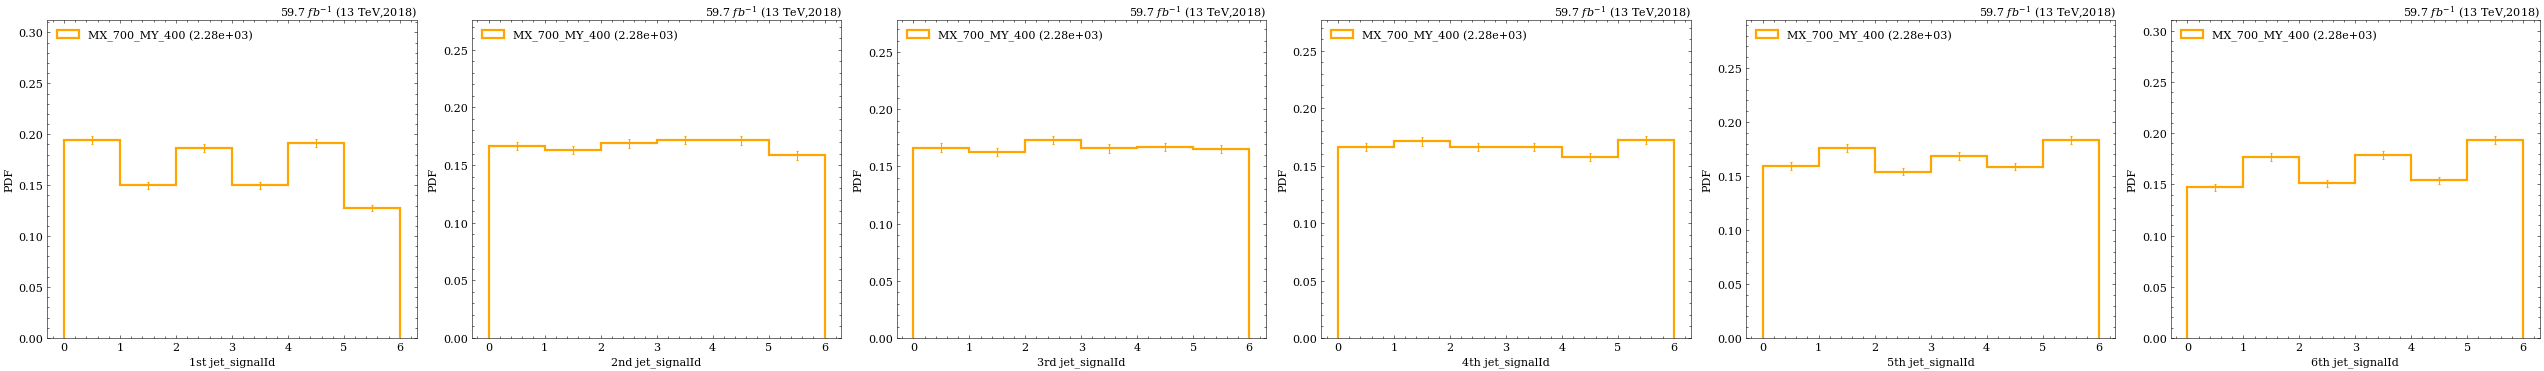

In [33]:
study.quick(
    sixb,
    legend=True,
    masks=complete_mask,
    # h_label_stat=higgs_comp,
    # transforms=lambda v:v+1,
    varlist=[f'jet_signalId[:,{i}]' for i in range(6)],
    efficiency=True,
    dim=-1,
)

100%|██████████| 3/3 [00:00<00:00, 12.59it/s]


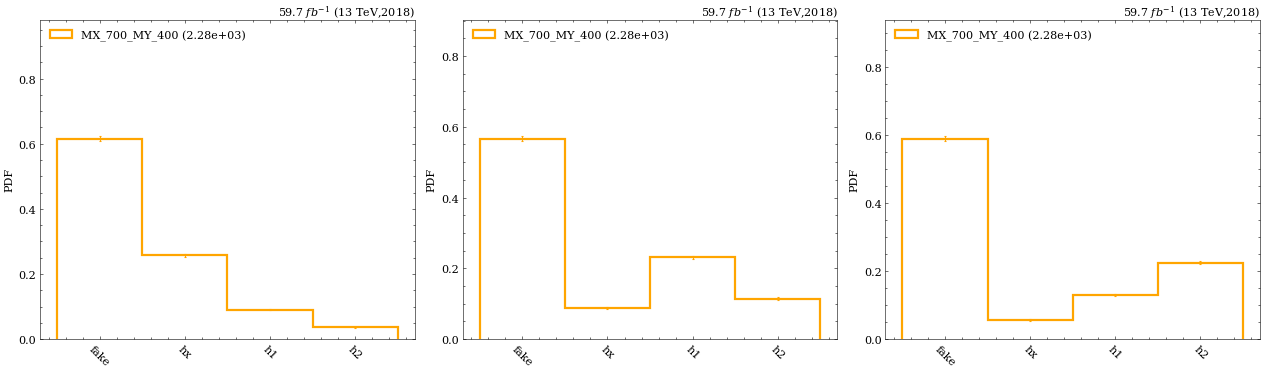

In [34]:
varinfo.gnn_higgs_signalId = dict(xlabel=['fake','hx','h1','h2'])
study.quick(
    sixb,
    legend=True,
    masks=complete_mask,
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=[f'gnn_higgs_signalId[:,{i}]' for i in range(3)],
    efficiency=True,
    dim=-1,
)

In [49]:
def fix_me(t):
    t.extend(gnn_higgs_signalId_offset = t.gnn_higgs_signalId+1)
(sixb).apply(fix_me)

[None]

In [64]:
def nfound_paired_h(t):
    higgs = ['HX','H1','H2']

    higgs_flag = [ (t[f'{h}_b1_genHflag'] != -1)&(t[f'{h}_b1_genHflag'] == t[f'{h}_b2_genHflag']) for h in higgs ]
    t.extend(nfound_paired_h_fixed = sum(higgs_flag))

sixb.apply(nfound_paired_h)

[None]

In [114]:
def higgs_signalId(t):
    higgs = ['HX','H1','H2']

    higgs_flag = { f'{h}_signalId':ak.where(t[f'{h}_b1_genHflag'] == t[f'{h}_b2_genHflag'], t[f'{h}_b1_genHflag'], -1) for h in higgs }

    higgs_correct = [id == i for i, (h, id) in enumerate(higgs_flag.items()) ]
    nhiggs_correct=  sum(higgs_correct)
    t.extend(**higgs_flag, nhiggs_correct = nhiggs_correct)
bias.apply(higgs_signalId)

[None]

In [115]:
def higgs_signalId(t):
    higgs = ['HX','H1','H2']

    higgs_flag = { f'{h}_signalId':(t.gnn_higgs_signalId[:,i]) for i,h in enumerate(higgs) }
    higgs_correct = [ id == i for i, (h, id) in enumerate(higgs_flag.items())]
    nhiggs_correct=  sum(higgs_correct)
    t.extend(**higgs_flag, nhiggs_correct = nhiggs_correct)
sixb.apply(higgs_signalId)


[None]

100%|██████████| 4/4 [00:00<00:00, 20.70it/s]


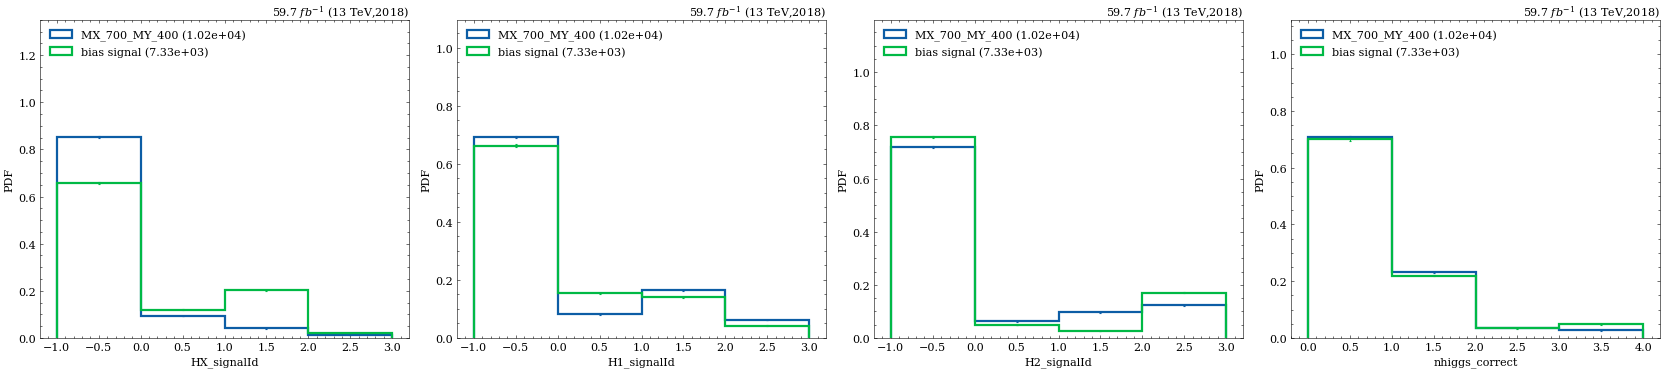

In [116]:
study.quick(
    sixb+bias, legend=True, h_color=None,
    stacked=False,
    # masks=complete_mask,
    varlist=['HX_signalId','H1_signalId','H2_signalId','nhiggs_correct'],
    # label=['nfound_paired_h','nfound_gnn_paired_h'],
    efficiency=True,
    dim=-1,
)

100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


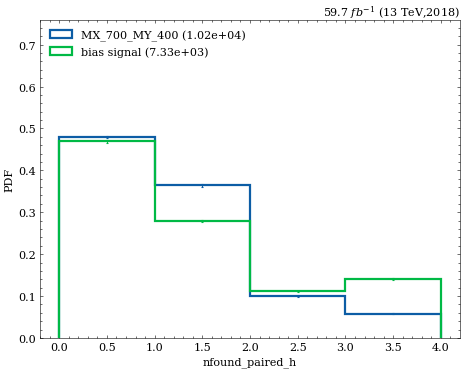

In [81]:
study.quick(
    sixb+bias, legend=True, h_color=None,
    stacked=False,
    # masks=complete_mask,
    varlist=['nfound_paired_h'],
    # label=['nfound_paired_h','nfound_gnn_paired_h'],
    efficiency=True,
)

100%|██████████| 4/4 [00:00<00:00, 13.15it/s]


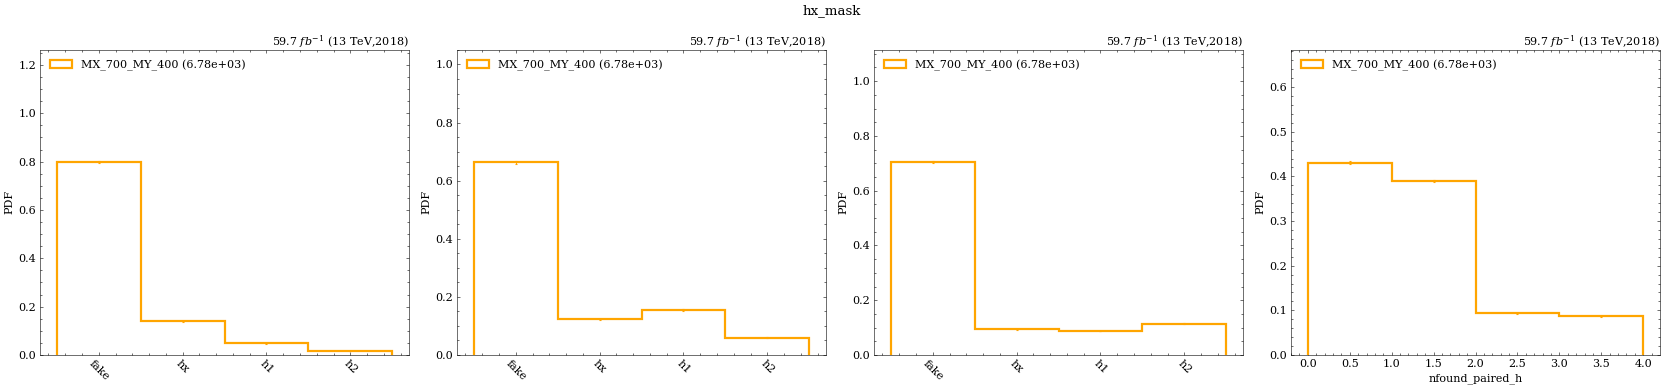

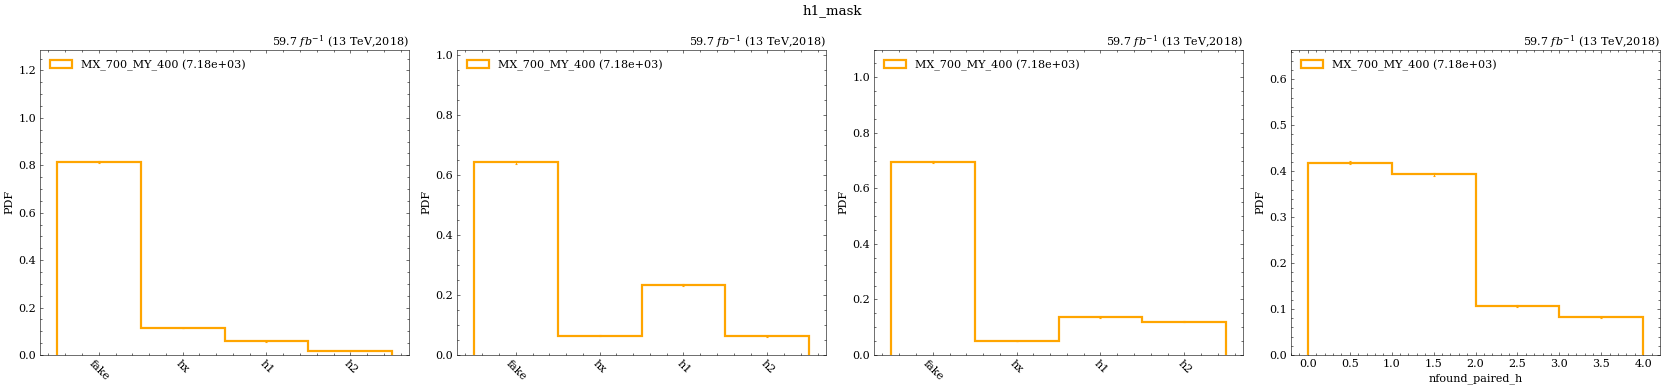

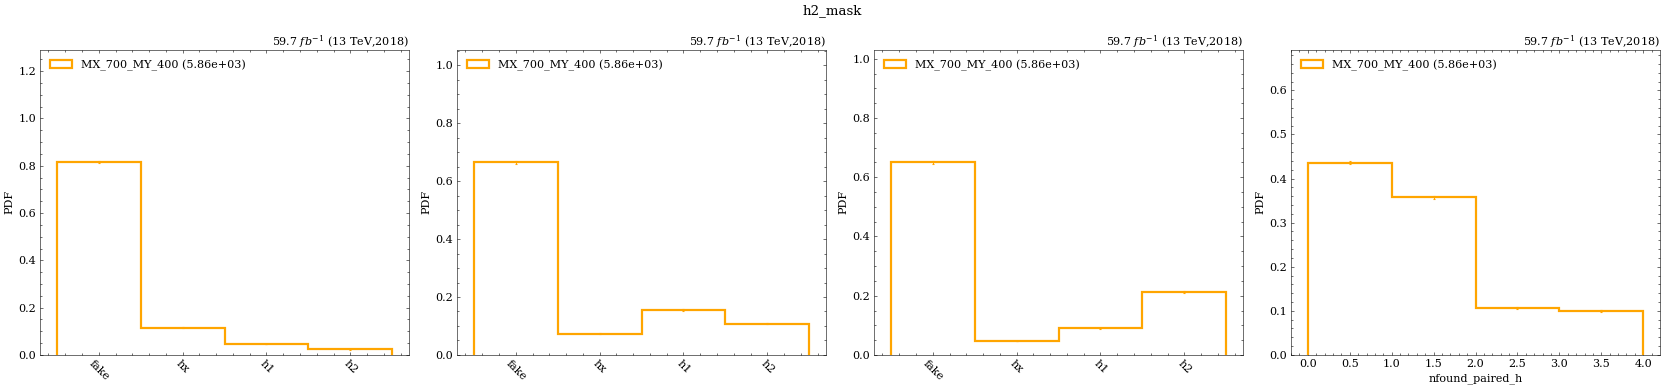

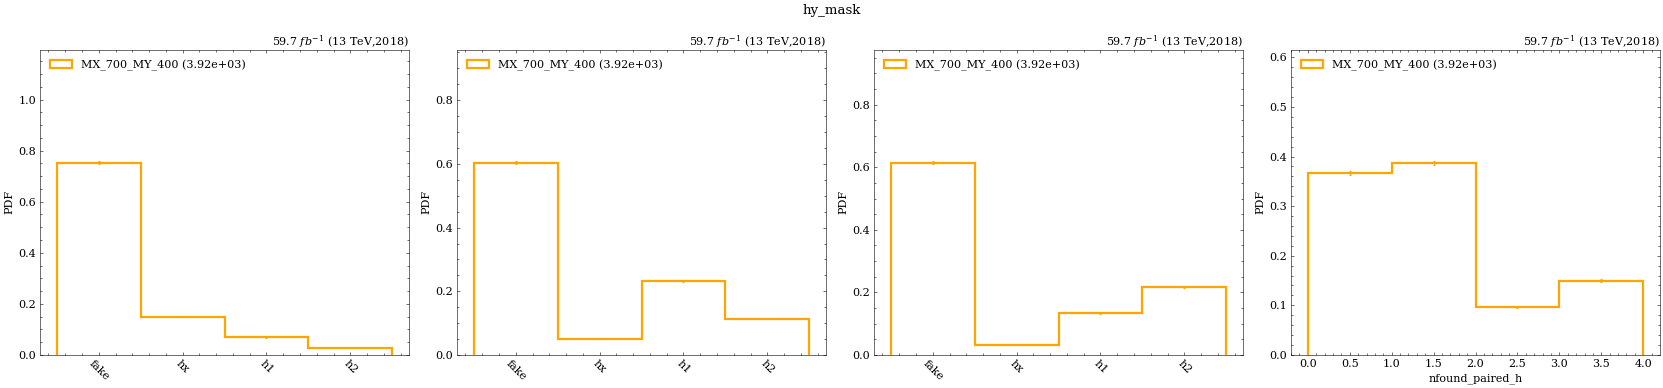

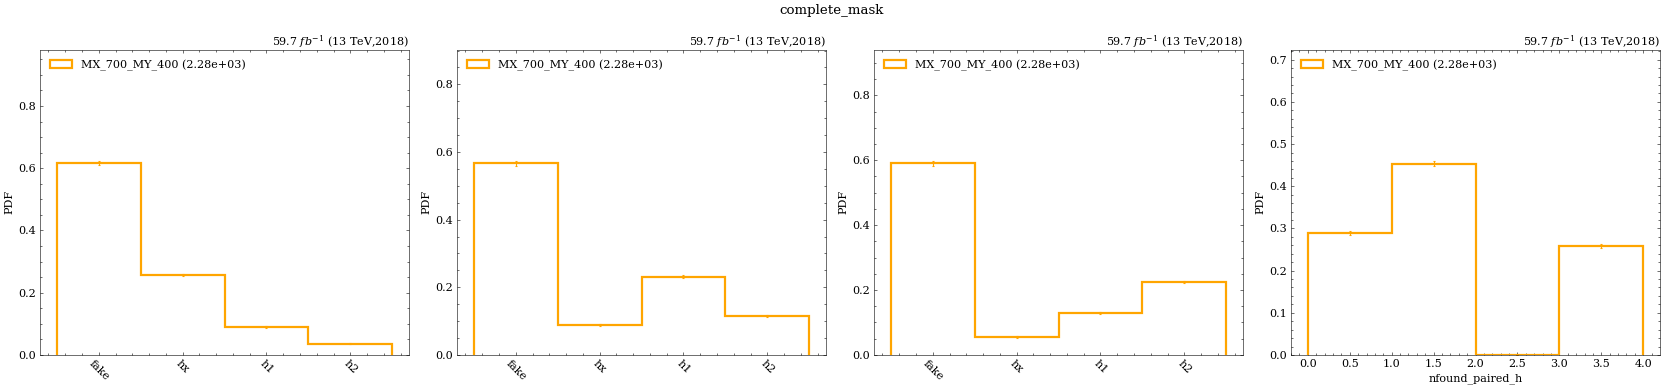

In [83]:
for mask in (hx_mask, h1_mask, h2_mask, hy_mask, complete_mask):
    study.quick(
        sixb,
        legend=True,
        masks=mask,
        suptitle=str(mask.__name__),
        # h_label_stat=higgs_comp,
        # transforms=lambda v:v+1,
        varlist=[f'gnn_higgs_signalId_offset[:,{i}]' for i in range(3)]+['nfound_paired_h'],
        efficiency=True,
        dim=-1,
    )

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


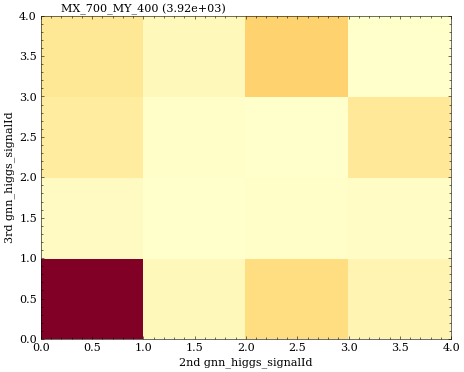

In [43]:
study.quick2d(
    sixb,
    legend=True,
    masks=hy_mask,
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=[f'gnn_higgs_signalId[:,1]','gnn_higgs_signalId[:,2]'],
    # efficiency=True,
    # log=True,

    dim=-1,
)

100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


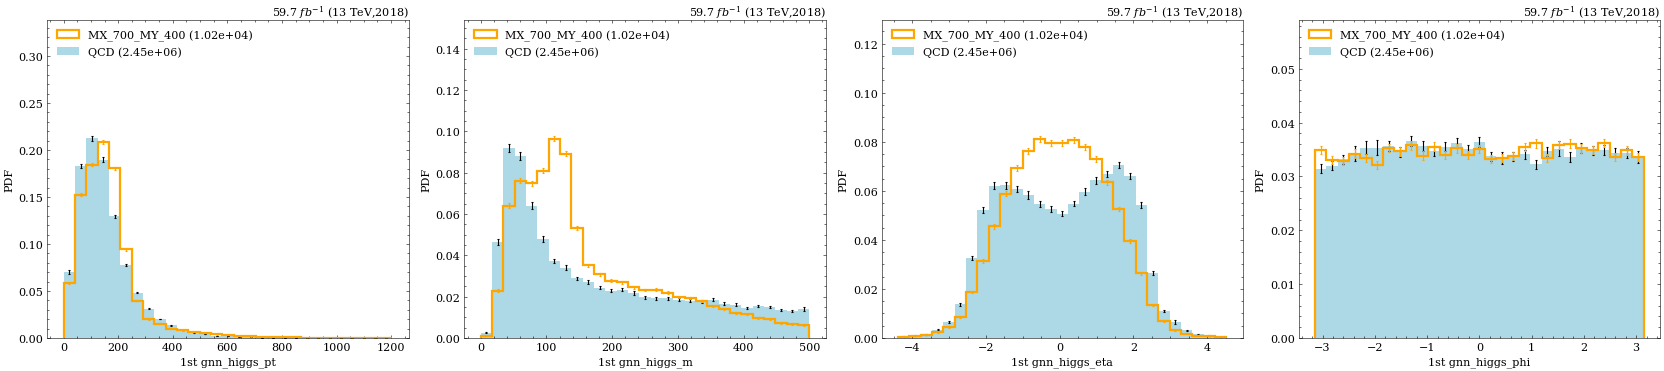

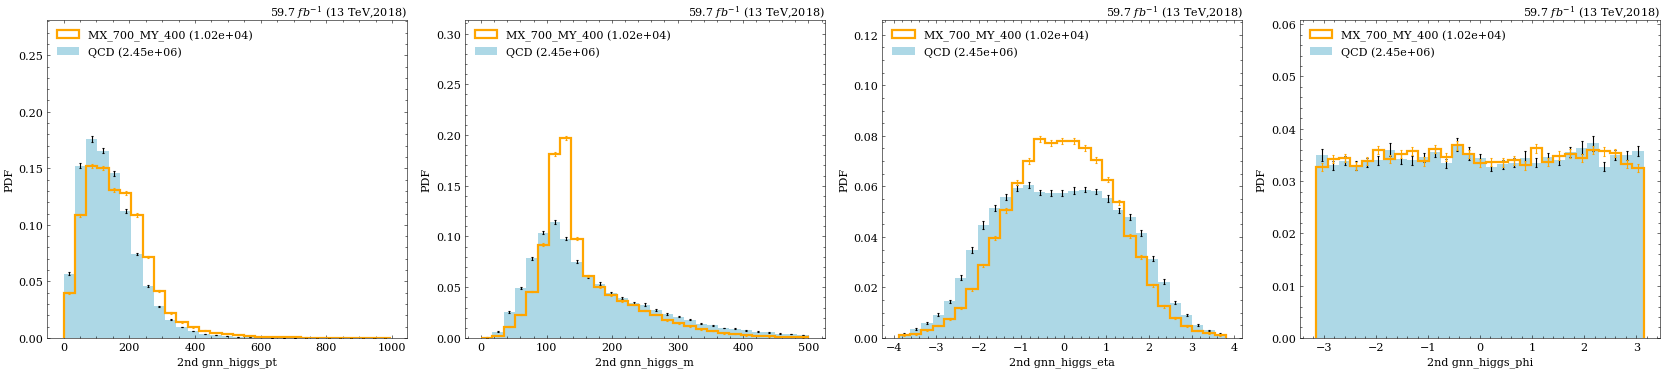

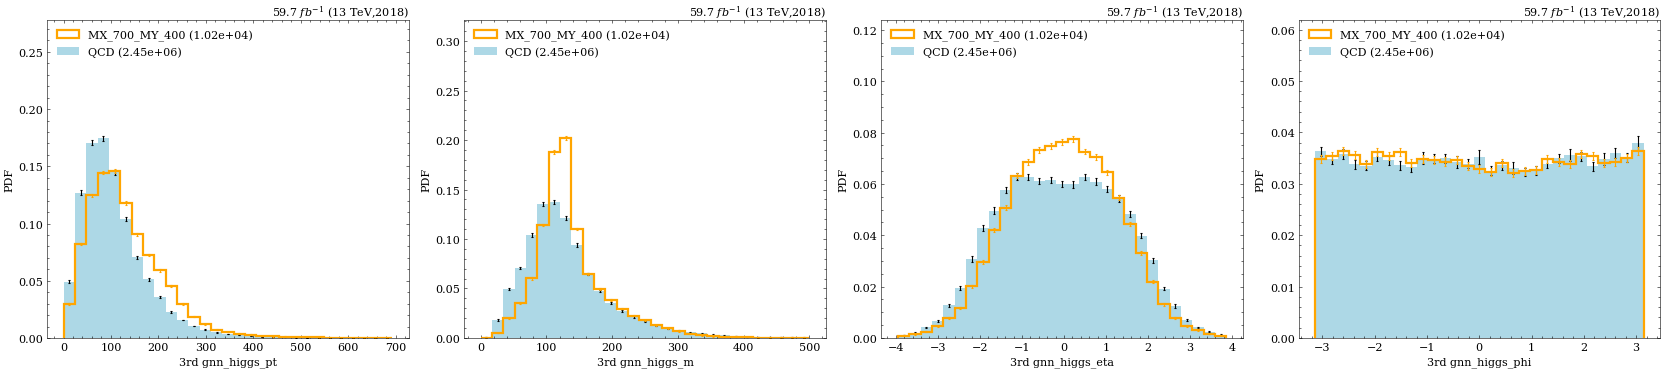

In [17]:
for i in range(3):
    study.quick(
        sixb+qcd,
        legend=True,
        varlist=[f'gnn_higgs_pt[:,{i}]',f'gnn_higgs_m[:,{i}]',f'gnn_higgs_eta[:,{i}]',f'gnn_higgs_phi[:,{i}]'],
        efficiency=True,
        dim=-1,
    )

100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


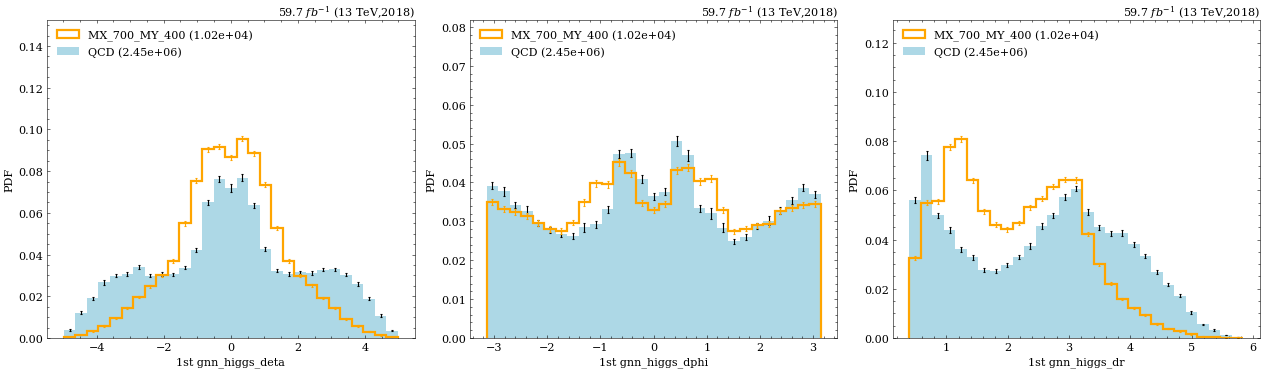

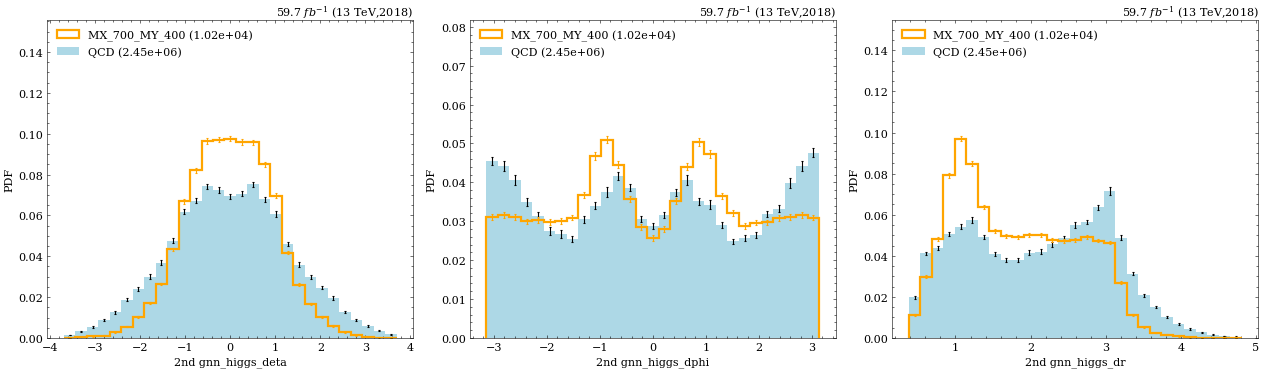

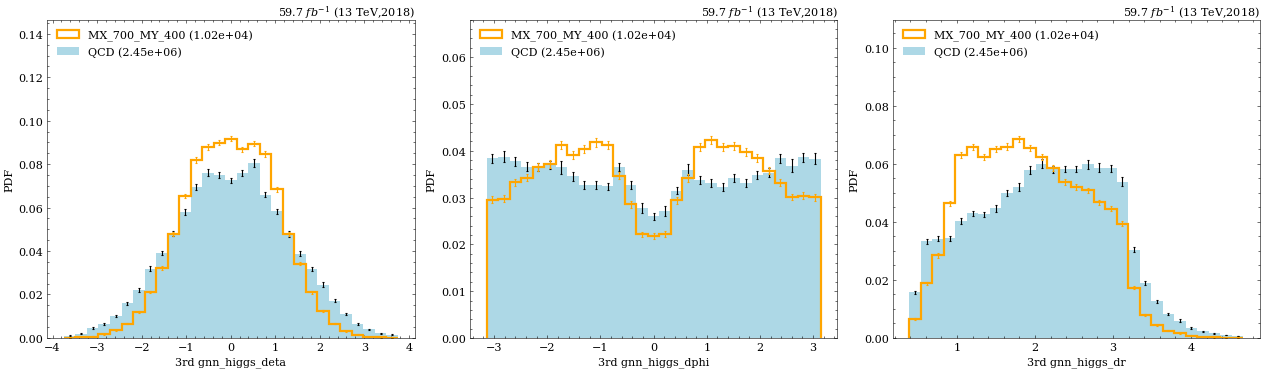

In [18]:
for i in range(3):
    study.quick(
        sixb+qcd,
        legend=True,
        varlist=[f'gnn_higgs_deta[:,{i}]',f'gnn_higgs_dphi[:,{i}]',f'gnn_higgs_dr[:,{i}]'],
        efficiency=True,
        dim=-1,
    )

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


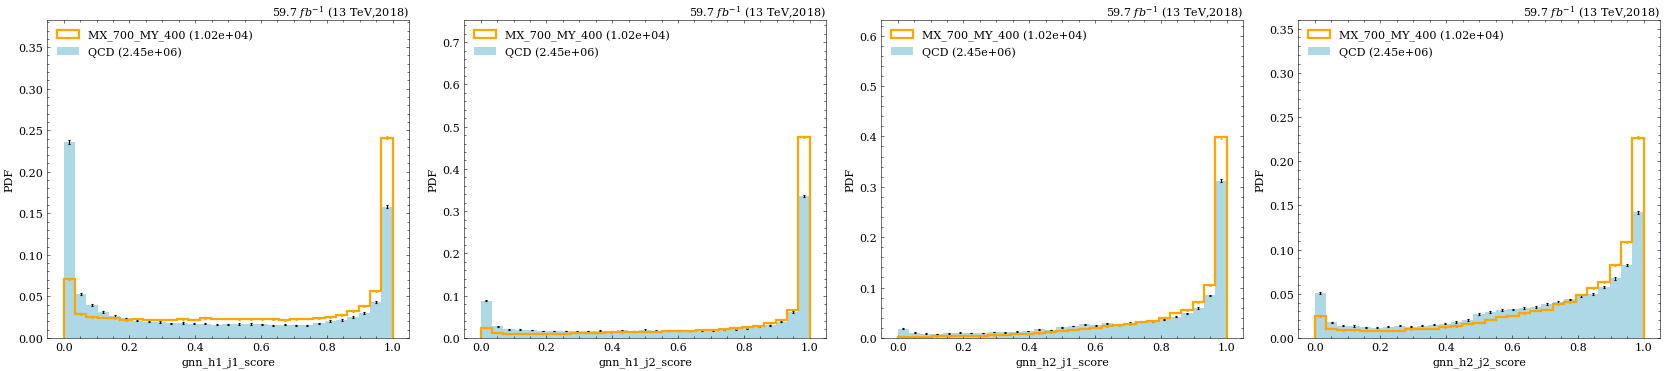

In [19]:
study.quick(
    sixb+qcd,
    legend=True,
    varlist=[f'gnn_h1_j1_score','gnn_h1_j2_score','gnn_h2_j1_score','gnn_h2_j2_score'],
    efficiency=True,
    dim=-1,
)

100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


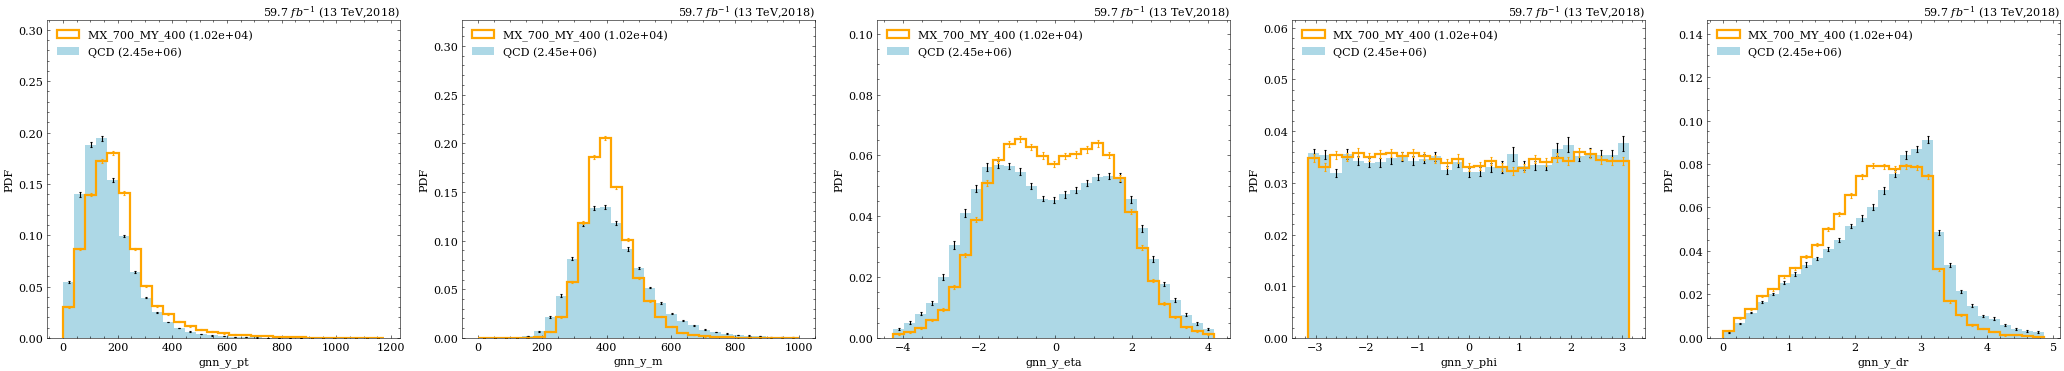

In [38]:
varinfo.gnn_y_m = dict(bins=(0,1000,30))
study.quick(
    sixb+qcd,
    legend=True,
    varlist=[f'gnn_y_{var}' for var in ('pt','m','eta','phi','dr')],
    dim=-1,
    efficiency=True,
)

100%|██████████| 6/6 [00:00<00:00, 12.76it/s]


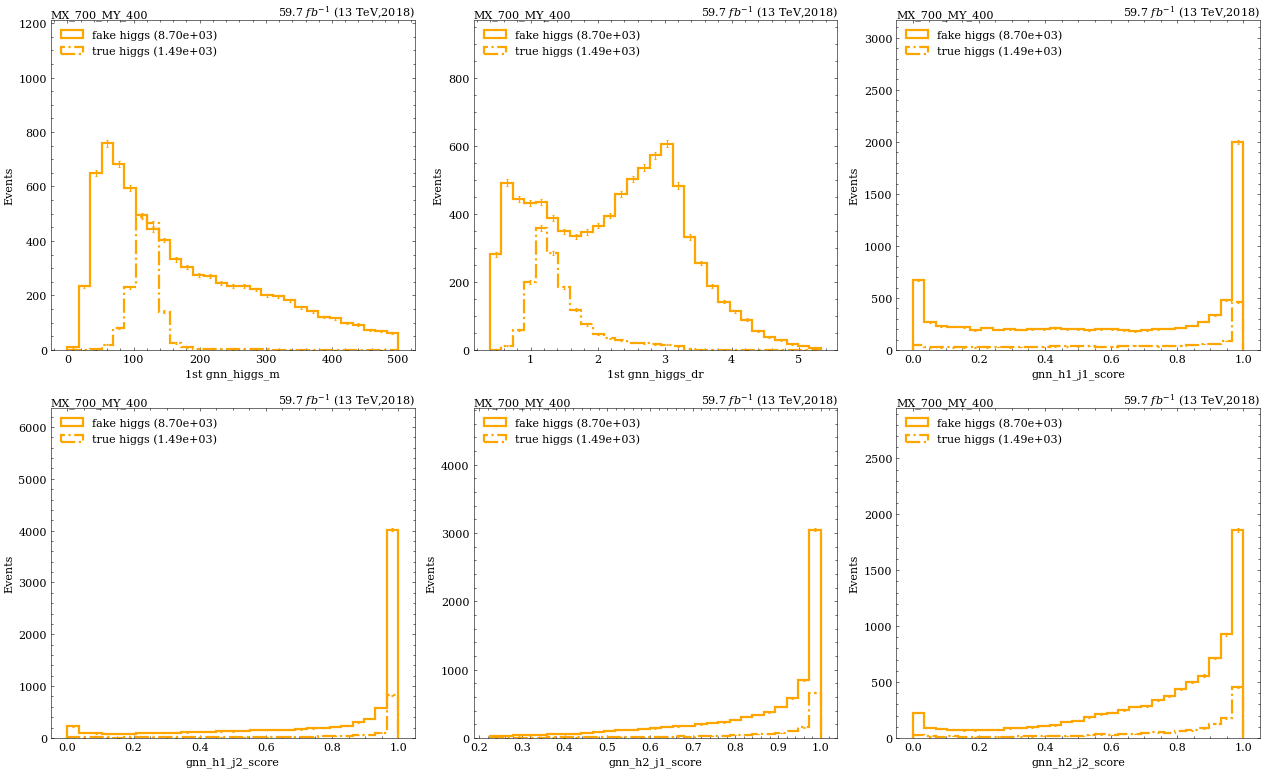

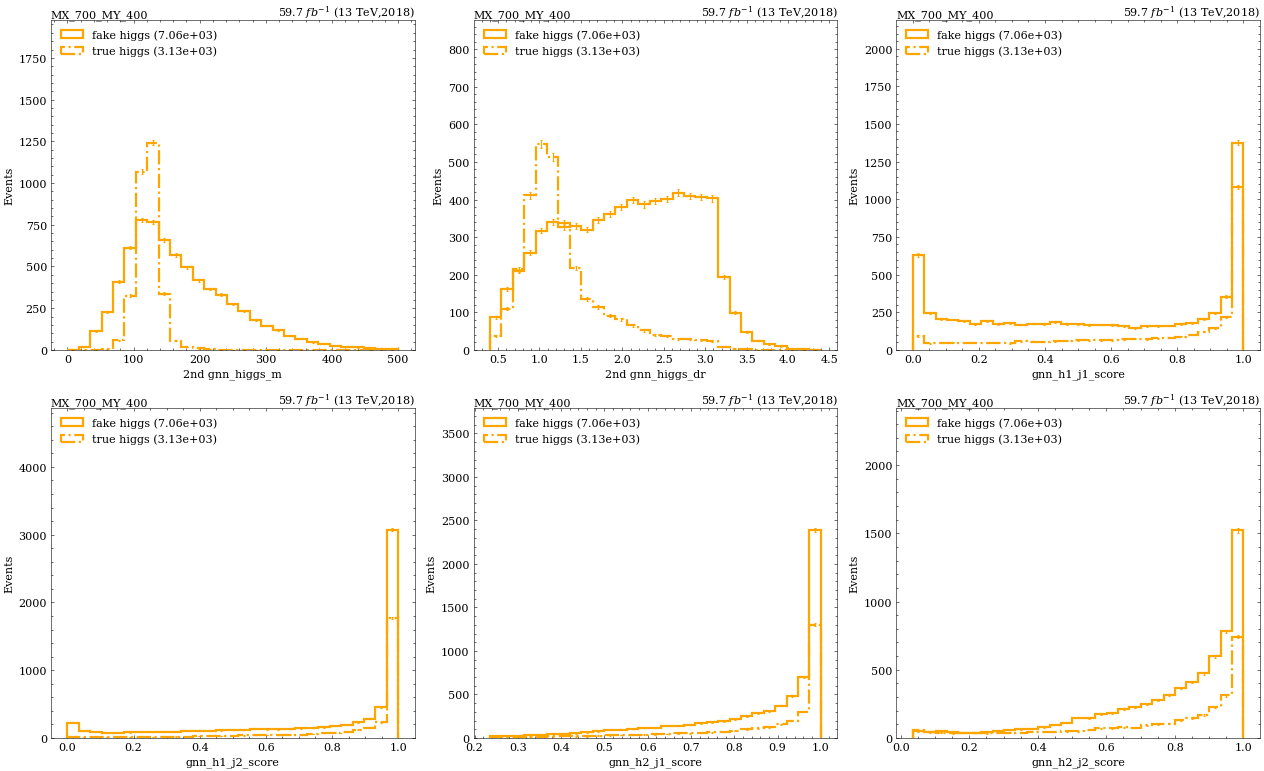

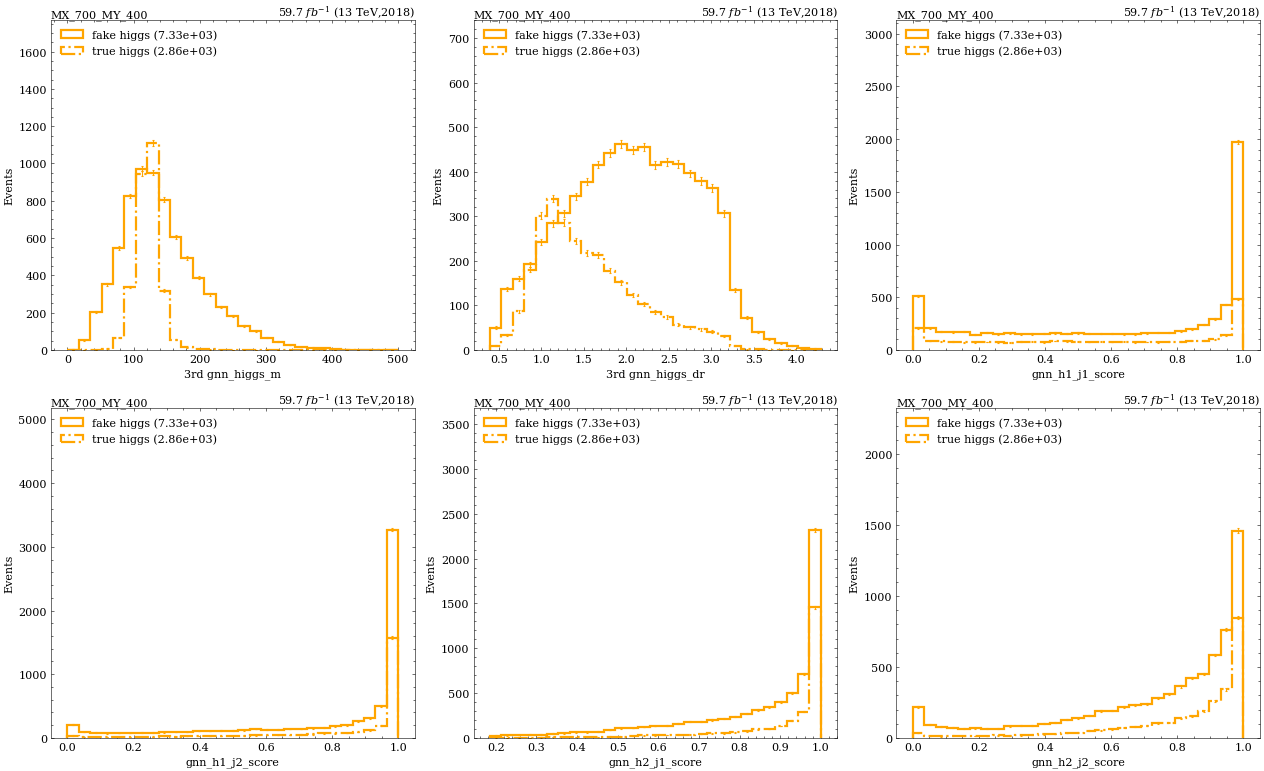

In [44]:
for i in range(3):
    figax = study.get_figax(6, dim=(2,3))
    study.compare_masks(
        sixb,
        masks=[lambda t:(t.gnn_higgs_signalId[:,i] == -1), lambda t:(t.gnn_higgs_signalId[:,i]>=0)],
        label=['fake higgs','true higgs'],
        legend=True,
        # masks=higgs_mask,
        varlist=[f'gnn_higgs_m[:,{i}]',f'gnn_higgs_dr[:,{i}]',f'gnn_h1_j1_score','gnn_h1_j2_score','gnn_h2_j1_score','gnn_h2_j2_score'],
        # binlist=[None, (0,500,30)],
        # efficiency=True,
        figax=figax,
    )

100%|██████████| 3/3 [00:00<00:00, 27.23it/s]


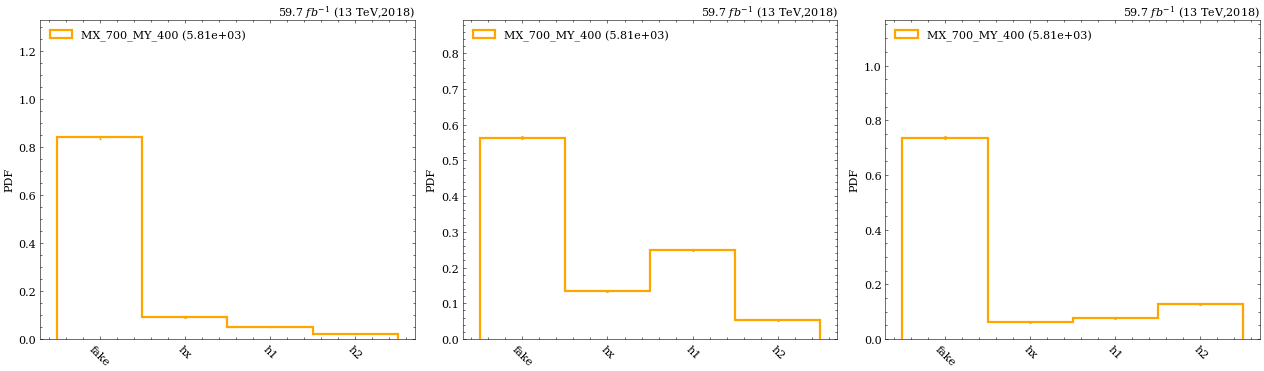

In [ ]:
varinfo.gnn_hx_signalId = dict(xlabel=['fake','hx','h1','h2'])

study.quick(
    sixb,
    legend=True,
    masks=lambda t:(t.gnn_higgs_dr[:,1]<2),
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=[f'gnn_higgs_signalId[:,{i}]' for i in range(3)],
    efficiency=True,
    dim=-1,
)

100%|██████████| 4/4 [00:00<00:00,  7.51it/s]


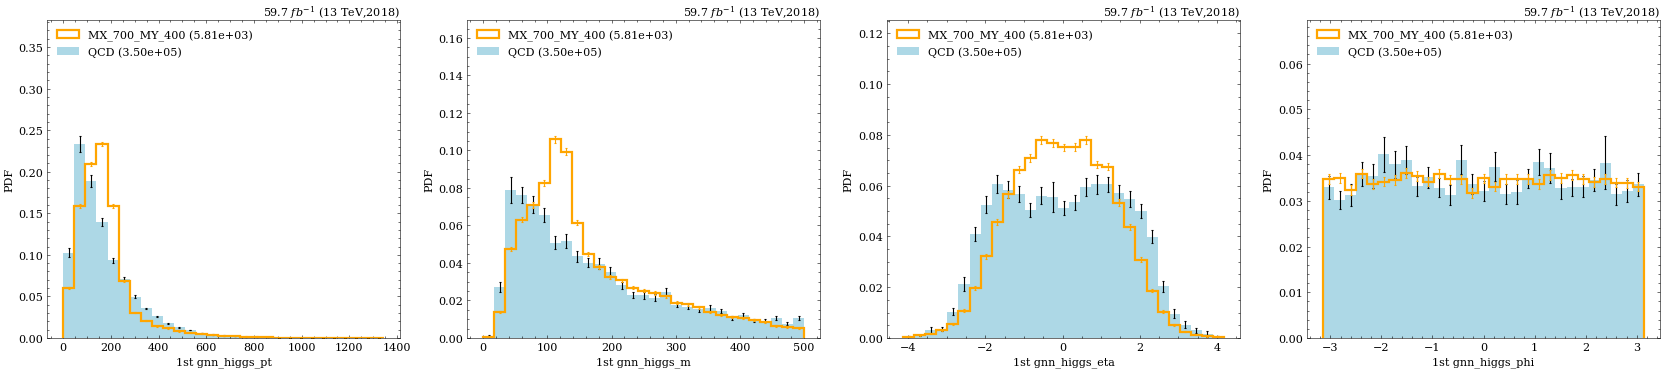

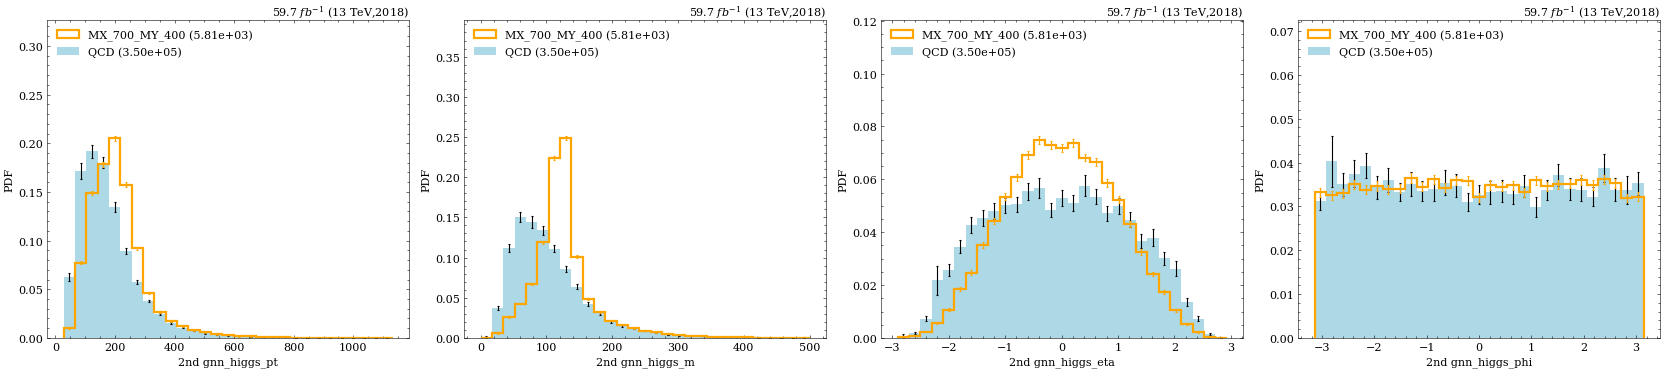

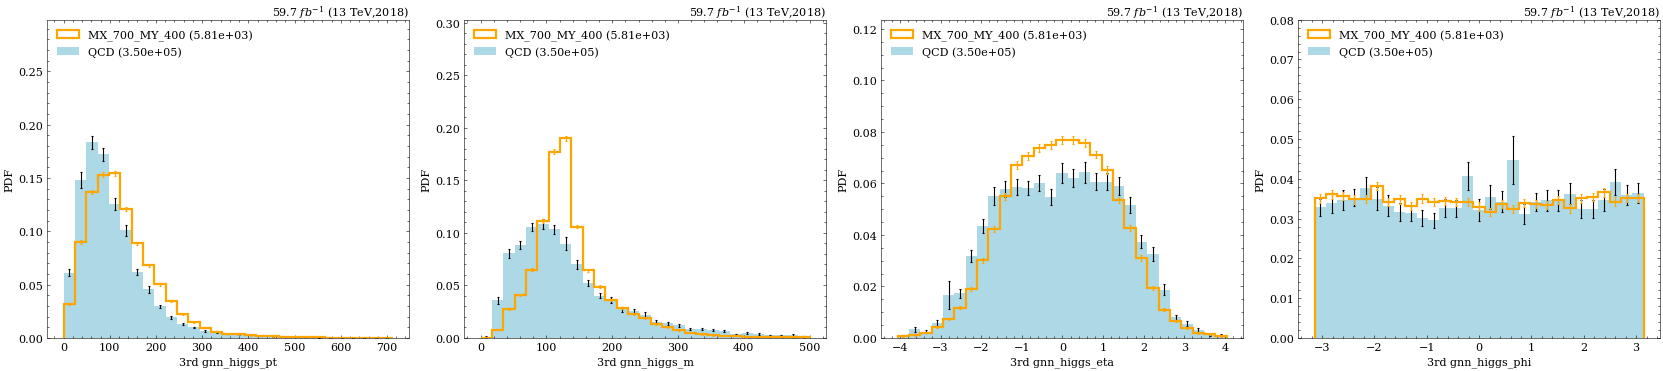

In [ ]:
for i in range(3):
    study.quick(
        sixb+qcd,
        legend=True,
        masks=lambda t:(t.gnn_higgs_dr[:,1]<2),
        varlist=[f'gnn_higgs_pt[:,{i}]',f'gnn_higgs_m[:,{i}]',f'gnn_higgs_eta[:,{i}]',f'gnn_higgs_phi[:,{i}]'],
        efficiency=True,
        dim=-1,
    )

100%|██████████| 4/4 [00:00<00:00,  7.59it/s]


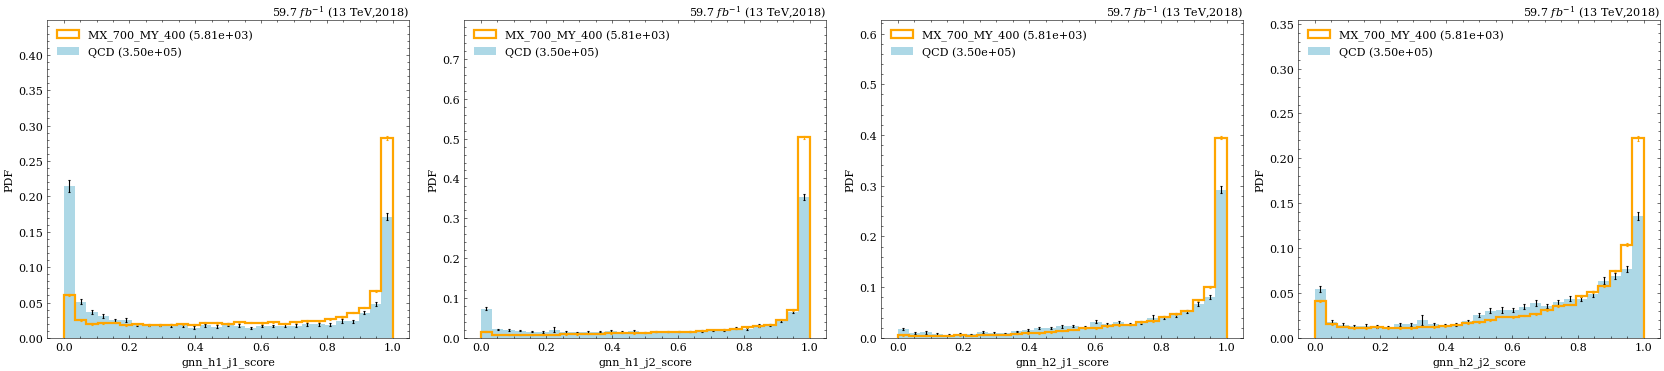

In [ ]:
study.quick(
    sixb+qcd,
    legend=True,
    masks=lambda t:(t.gnn_higgs_dr[:,1]<2),
    varlist=[f'gnn_h1_j1_score','gnn_h1_j2_score','gnn_h2_j1_score','gnn_h2_j2_score'],
    efficiency=True,
    dim=-1,
)

100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


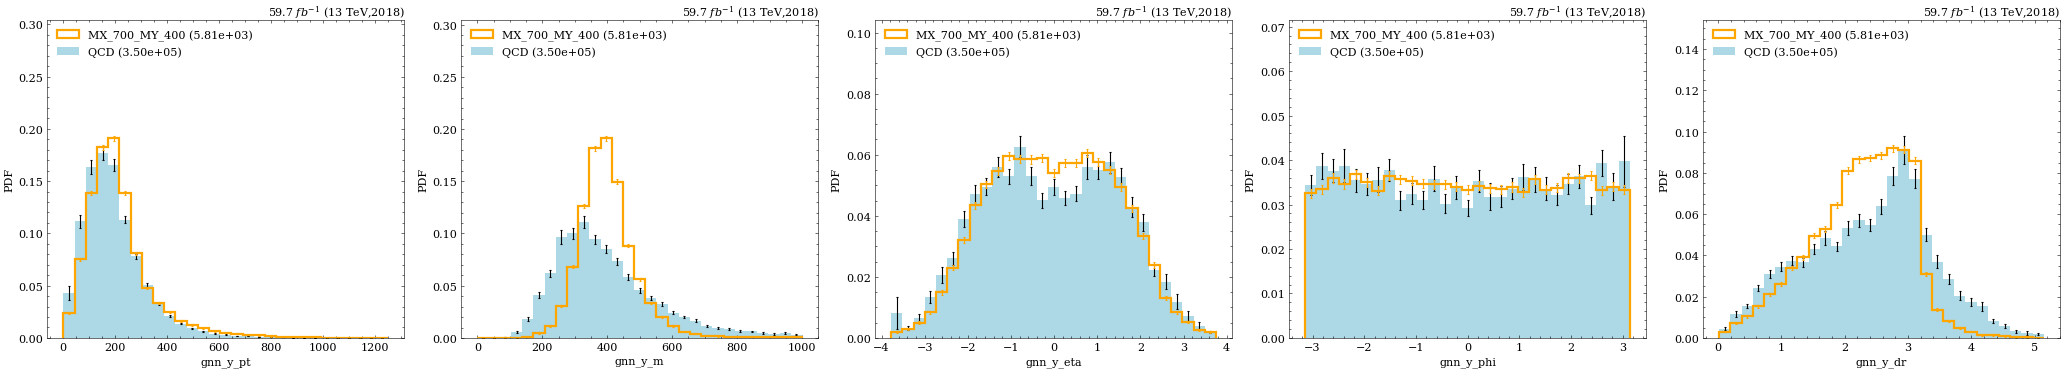

In [ ]:
study.quick(
    sixb+qcd,
    legend=True,
    masks=lambda t:(t.gnn_higgs_dr[:,1]<2),
    varlist=[f'gnn_y_{var}' for var in ('pt','m','eta','phi','dr')],
    dim=-1,
    efficiency=True,
)